### *Data Analysis*
##  LDA on the Speaker Corpus - EU  
---
*conducted in April 2022*

In [1]:
# Import necessary libraries
import nltk, re, pprint
import json
from nltk import word_tokenize
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
import nltk.data
import os.path 
import glob
import pandas as pd
import os
import re
from nltk.corpus import PlaintextCorpusReader 
from nltk.app import concordance
from nltk.corpus import BracketParseCorpusReader
import numpy as np
import contractions
import statsmodels.formula.api as smf
import altair as alt
import tmtoolkit
import spacy as spacy
import logging, warnings
from tmtoolkit.corpus import Corpus
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
nltk.download('omw-1.4')
import pickle
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models
import docx


/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/charlottekaiser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Prerequisites: stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
# Add sample specific stop words that are redundant and have no substantial relevance; also add words that are project-specific stopwords
stopwords.add('president')
stopwords.add('mr.')
stopwords.add('mrs.')
stopwords.add('ms.')
stopwords.add('mr')
stopwords.add('mrs')
stopwords.add('ms')
stopwords.add('commission')
stopwords.add('congress')
stopwords.add('speaker')
stopwords.add('also')
stopwords.add('artificial')
stopwords.add('intelligence')
stopwords.add('ai')
stopwords.add('pro')
stopwords.add('tempore')
stopwords.add('representative')
stopwords.add('thank')
stopwords.add('dear')
stopwords.add('rapporteur')
stopwords.add('lady')
stopwords.add('committee')
stopwords.add('report')
stopwords.add('legislation')
stopwords.add('like')
stopwords.add('subcommittee')
stopwords.add('gentleman')
stopwords.add('r')
stopwords.add('colleague')
stopwords.add('madam')
stopwords.add('ha')
stopwords.add('wa')
stopwords.add('for')
stopwords.add('in')
stopwords.add('-')
stopwords.add(',')
stopwords.add('and')
stopwords.add('house')
stopwords.add('chairwoman')
stopwords.add('agency')
stopwords.add('sponsor')
stopwords.add('gentlewoman')
stopwords.add('verts')
stopwords.add('renew')
stopwords.add('bill')
stopwords.add('datum')
stopwords.add('year')
stopwords.add('amendment')
stopwords.add('president')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlottekaiser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
### 1. Load in dataframe and pre-process EU datasets
---

In [4]:
# Open prepared dataframe
os.chdir('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis')
with open('raw_corpus_individual_eu.csv') as f:
    corpus = pd.read_csv(f)
corpus.drop('Unnamed: 0', axis=1, inplace=True)
f.close()
df = corpus[['level', 'speaker', 'gender', 'member_state', 'EP', 'party_group', 'text']]

# Data from text column to list
data = df.text.values.tolist()

# Remove single quotes and slashes
data = [re.sub("\'", "", sent) for sent in data]

# Clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)


In [6]:
# Define functions for pre-processing: stopwords, create bigrams, lemmatization
## Lemmatization gets the root, for ref, see: https://spacy.io/api/annotation
def rm_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Remove Stop Words
words_nostops = rm_stopwords(data_words)

# Form Bigrams
words_bigrams = bigrams(words_nostops)

# Initialize spacy 'en' model
nlp = spacy.load("en_core_web_sm")

# Lemmatize, keep noun, adj, vb, adv
ready_corpus_eu = lemmatize(words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(ready_corpus_eu[:1])

[['group', 'gentleman', 'war', 'medium', 'freedom', 'go', 'several', 'hour', 'war', 'polish', 'citizen', 'know', 'truth', 'authority', 'decide', 'truth', 'lie', 'taxis', 'authority', 'really', 'obedience', 'citizen', 'authority', 'want', 'cultivate', 'obedience', 'citizen', 'help', 'medium', 'subordinate', 'hungary', 'authority', 'member', 'state', 'deprive', 'citizen', 'right', 'reliable', 'information', 'parliament', 'say', 'approval', 'talk', 'stomp', 'foot', 'scream', 'limit', 'helplessness', 'become', 'humiliation', 'humiliation', 'stand', 'alone', 'freedom', 'democracy', 'roman', 'maxim', 'say', 'resist', 'force', 'force', 'force', 'adequate', 'threat', 'call', 'entire', 'accordingly', 'call', 'free', 'medium', 'world', 'show', 'solidarity', 'polish', 'free', 'medium', 'happen', 'happen', 'end', 'leave', 'time', 'spend', 'silence', 'silence', 'warning', 'action', 'moment', 'silence', 'soon', 'become', 'minute', 'silence', 'silence', 'coffin', 'polish', 'democracy', 'polish']]


---
### 2. Build LDA model EU
---

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(ready_corpus_eu)

# Create Corpus
texts = ready_corpus_eu

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Term Document Frequency (TDF)
corpus = [id2word.doc2bow(text) for text in texts]

# TDF readable for humans
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:]]

[[('accordingly', 1),
  ('action', 1),
  ('adequate', 1),
  ('alone', 1),
  ('approval', 1),
  ('authority', 4),
  ('become', 2),
  ('call', 2),
  ('citizen', 4),
  ('coffin', 1),
  ('cultivate', 1),
  ('decide', 1),
  ('democracy', 2),
  ('deprive', 1),
  ('end', 1),
  ('entire', 1),
  ('foot', 1),
  ('force', 3),
  ('free', 2),
  ('freedom', 2),
  ('gentleman', 1),
  ('go', 1),
  ('group', 1),
  ('happen', 2),
  ('help', 1),
  ('helplessness', 1),
  ('hour', 1),
  ('humiliation', 2),
  ('hungary', 1),
  ('information', 1),
  ('know', 1),
  ('leave', 1),
  ('lie', 1),
  ('limit', 1),
  ('maxim', 1),
  ('medium', 4),
  ('member', 1),
  ('minute', 1),
  ('moment', 1),
  ('obedience', 2),
  ('parliament', 1),
  ('polish', 4),
  ('really', 1),
  ('reliable', 1),
  ('resist', 1),
  ('right', 1),
  ('roman', 1),
  ('say', 2),
  ('scream', 1),
  ('several', 1),
  ('show', 1),
  ('silence', 5),
  ('solidarity', 1),
  ('soon', 1),
  ('spend', 1),
  ('stand', 1),
  ('state', 1),
  ('stomp', 1),

---
#### 2.1 Run simple LDA model

In [9]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print out topics
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.037*"digital" + 0.032*"digitization" + 0.027*"cybersecurity" + 0.019*"advance"')
(1, '0.032*"game" + 0.017*"billion" + 0.017*"central" + 0.012*"arbitrary"')
(2, '0.021*"need" + 0.016*"consumer" + 0.015*"european" + 0.014*"ban"')
(3, '0.020*"use" + 0.018*"technology" + 0.012*"datum" + 0.009*"work"')
(4, '0.016*"say" + 0.016*"actually" + 0.015*"really" + 0.013*"right"')
(5, '0.053*"digital" + 0.018*"technology" + 0.017*"european" + 0.016*"need"')
(6, '0.028*"trade" + 0.015*"work" + 0.012*"set" + 0.012*"think"')
(7, '0.096*"woman" + 0.033*"education" + 0.021*"gender" + 0.021*"stem"')
(8, '0.010*"history" + 0.009*"recently" + 0.009*"lead" + 0.009*"civilization"')
(9, '0.032*"representation" + 0.021*"regime" + 0.016*"equal" + 0.014*"humanity"')
(10, '0.017*"use" + 0.017*"freedom" + 0.013*"right" + 0.012*"expression"')
(11, '0.016*"decide" + 0.010*"democracy" + 0.010*"clear" + 0.009*"question"')
(12, '0.015*"man" + 0.015*"goal" + 0.014*"technological" + 0.011*"reality"')
(13, '0.028*"

In [11]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=ready_corpus_eu, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.096194290715248

Coherence Score:  0.3698878544632042


In [12]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/charlo

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.219370  0.048246       1        1  25.550560
17    -0.195078 -0.161920       2        1  13.043513
10    -0.138983 -0.141182       3        1  12.430835
5     -0.228033  0.152517       4        1  12.078460
6     -0.189495 -0.052465       5        1  10.973774
7     -0.066750  0.186682       6        1   5.080682
13    -0.034596 -0.143972       7        1   3.415179
2     -0.037205 -0.001156       8        1   3.413515
0     -0.047039  0.170070       9        1   2.790086
4      0.020463 -0.045424      10        1   2.494780
12    -0.015425  0.078455      11        1   2.481395
18     0.039374 -0.059002      12        1   1.944829
11     0.077996 -0.083699      13        1   1.487219
19     0.091372 -0.033733      14        1   1.347414
14     0.156560 -0.011709      15        1   0.491269
1      0.166672  0.021391      16        1   0.429276
8      0.155823  0.014613      17        1   0.297961
9      0.164833  0.026267      18        1   0.226785
15     0.149436  0.018006      19        1   0.011355
16     0.149445  0.018017      20        1   0.011114, topic_info=           Term        Freq       Total Category  logprob  loglift
609       woman  132.000000  132.000000  Default  30.0000  30.0000
88      digital  358.000000  358.000000  Default  29.0000  29.0000
698       trade   86.000000   86.000000  Default  28.0000  28.0000
126      online   94.000000   94.000000  Default  27.0000  27.0000
1012  education   88.000000   88.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
875        deal    0.000778   28.074734  Topic20  -8.2301  -1.3893
166         big    0.000778   38.046192  Topic20  -8.2301  -1.6932
360        take    0.000778   88.986282  Topic20  -8.2301  -2.5429
218         see    0.000778   83.054010  Topic20  -8.2301  -2.4739
885        well    0.000778   77.045915  Topic20  -8.2301  -2.3989

[1201 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
157      13  0.931465   abdicate
2333     11  0.876825      abide
799       1  0.445669       able
799       2  0.083563       able
799       3  0.139272       able
...     ...       ...        ...
1786      8  0.926517  worldwide
621       2  0.848872      wrong
450       8  0.835269  yesterday
366      10  0.254480    youtube
366      12  0.763439    youtube

[2282 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 18, 11, 6, 7, 8, 14, 3, 1, 5, 13, 19, 12, 20, 15, 2, 9, 10, 16, 17])

---
#### 2.2 Run more mature Mallet model

In [42]:
# Download: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
path_mallet = '/Users/charlottekaiser/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(path_mallet, corpus=corpus, num_topics=20, id2word=id2word)

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 665
total tokens: 22692
<10> LL/token: -9.12808


KeyboardInterrupt: 

In [44]:
# Print out topics
topics = ldamallet.print_topics(num_words=4)
for topic in topics:
    print(topic)

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=ready_corpus_eu, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

(0, '0.133*"datum" + 0.059*"ensure" + 0.037*"create" + 0.032*"technology"')
(1, '0.054*"medium" + 0.040*"people" + 0.029*"call" + 0.025*"speech"')
(2, '0.066*"today" + 0.064*"time" + 0.056*"society" + 0.048*"great"')
(3, '0.115*"freedom" + 0.072*"democracy" + 0.055*"expression" + 0.029*"democratic"')
(4, '0.107*"citizen" + 0.068*"protect" + 0.054*"protection" + 0.039*"lead"')
(5, '0.050*"group" + 0.044*"issue" + 0.036*"action" + 0.033*"child"')
(6, '0.114*"woman" + 0.029*"man" + 0.025*"gender" + 0.024*"stem"')
(7, '0.095*"important" + 0.078*"european" + 0.045*"opportunity" + 0.040*"make"')
(8, '0.148*"digital" + 0.038*"technology" + 0.026*"investment" + 0.025*"economy"')
(9, '0.080*"public" + 0.040*"internet" + 0.037*"private" + 0.035*"big"')
(10, '0.068*"technology" + 0.061*"education" + 0.035*"sector" + 0.025*"ethical"')
(11, '0.075*"good" + 0.052*"human" + 0.047*"make" + 0.046*"decision"')
(12, '0.068*"parliament" + 0.039*"fundamental" + 0.038*"day" + 0.032*"make"')
(13, '0.059*"fun

---
#### 2.3 Find coherence scores for LDA models with different number of topics and identify most coherent model

In [45]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(path_mallet, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=ready_corpus_eu, start=2, limit=40, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 665
total tokens: 22692
<10> LL/token: -8.27086
<20> LL/token: -8.09337
<30> LL/token: -8.01661
<40> LL/token: -7.97698

0	25	digital technology datum work woman european future important education support area ensure company fundamental_right development sector human challenge make create 
1	25	freedom citizen platform democracy time rule online people trade good public world european society protect democratic make expression set system 

<50> LL/token: -7.9375
<60> LL/token: -7.92439
<70> LL/token: -7.91632
<80> LL/token: -7.90446
<90> LL/token: -7.89991

0	25	digital technology european work datum woman important ensure future make company education support area fundamental_right development sector challenge create innovation 
1	25	freedom citizen platform democracy time rule people online society trade good public world human protect democratic clear regulation expression set 

<100> LL/token: -7.89197
<110>

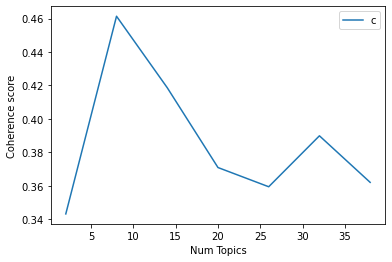

In [37]:
# Visualize 
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
# Save as file
os.chdir('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/20_results/10_analysis/LDA_speaking-points')
plt.savefig('coherence-check_eu.png')

In [38]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3432
Num Topics = 8  has Coherence Value of 0.4614
Num Topics = 14  has Coherence Value of 0.4187
Num Topics = 20  has Coherence Value of 0.3709
Num Topics = 26  has Coherence Value of 0.3594
Num Topics = 32  has Coherence Value of 0.3899
Num Topics = 38  has Coherence Value of 0.362


---
#### 2.4 Run LDA Mallet model that is most coherent as per step 2.3

In [39]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)

# Print out topics
topics = optimal_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.046*"woman" + 0.032*"technology" + 0.028*"education" + 0.016*"field" + 0.015*"sector" + 0.015*"high" + 0.012*"man" + 0.012*"culture" + 0.012*"future" + 0.012*"framework"')
(1, '0.031*"trade" + 0.030*"work" + 0.024*"set" + 0.021*"make" + 0.021*"parliament" + 0.019*"issue" + 0.017*"important" + 0.017*"global" + 0.016*"standard" + 0.015*"cooperation"')
(2, '0.048*"datum" + 0.030*"ensure" + 0.028*"technology" + 0.023*"development" + 0.022*"regulation" + 0.021*"future" + 0.019*"opportunity" + 0.016*"consumer" + 0.015*"create" + 0.015*"approach"')
(3, '0.105*"digital" + 0.028*"european" + 0.025*"support" + 0.023*"important" + 0.018*"work" + 0.017*"economy" + 0.016*"innovation" + 0.016*"area" + 0.013*"strengthen" + 0.013*"investment"')
(4, '0.041*"time" + 0.031*"citizen" + 0.029*"world" + 0.025*"challenge" + 0.023*"european" + 0.023*"great" + 0.020*"market" + 0.020*"life" + 0.019*"place" + 0.019*"gentleman"')
(5, '0.045*"freedom" + 0.039*"platform" + 0.033*"democracy" + 0.029*"online" 

In [46]:
# Store prevalence scores of all topics across documents (i.e. speaker entries)
for i in range(0,173):
    globals()[f"prev{i}"] = optimal_model[corpus[i]]

In [48]:
prev_score_eu = [prev0, prev1 ,  prev2 ,  prev3 ,  prev4 ,  prev5 ,  prev6 ,  prev7 ,  prev8 ,  prev9,  prev10 ,  prev11 , prev12 , prev13, prev14, prev15, prev16, prev17, prev18, prev19, prev20, prev21, prev22, prev23, prev24 , prev25, prev26, prev27, prev28, prev29, prev30, prev31, prev32, prev33, prev34, prev35, prev36, prev37, prev38, prev39, prev40, prev41, prev42, prev43, prev44, prev45, prev46, prev47, prev48, prev49, prev50, prev51, prev52, prev53, prev54, prev55, prev56, prev57, 
prev58, prev59, prev60, prev61, prev62, prev63 ,  prev64, prev65, prev66 , prev67 , prev68 , prev69 , prev70 , prev71 , prev72 , prev73 , prev74 , prev75 , prev76 , prev77 , prev78, prev79
,prev80
,prev81
,prev82
,prev83
,prev84
,prev85
,prev86
,prev87
,prev88
,prev89
,prev90
,prev91
,prev92
,prev93
,prev94
,prev95
,prev96
,prev97
,prev98
,prev99
,prev100
,prev101
,prev102
,prev103
,prev104
,prev105
,prev106
,prev107
,prev108
,prev109
,prev110
,prev111
,prev112
,prev113
,prev114
,prev115
,prev116
,prev117
,prev118
,prev119
,prev120
,prev121
,prev122
,prev123
,prev124
,prev125
,prev126
,prev127
,prev128
,prev129
,prev130
,prev131
,prev132
,prev133
,prev134
,prev135
,prev136
,prev137
,prev138
,prev139
,prev140
,prev141
,prev142
,prev143
,prev144
,prev145
,prev146
,prev147
,prev148
,prev149
,prev150
,prev151
,prev152
,prev153
,prev154
,prev155
,prev156
,prev157
,prev158
,prev159
,prev160
,prev161
,prev162
,prev163
,prev164
,prev165
,prev166
,prev167
,prev168
,prev169
,prev170
,prev171
,prev172]

In [49]:
# Find topic most dominant for each debate
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=ready_corpus_eu):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=ready_corpus_eu)

# Format
df_topics_aggregate = df_topic_sents_keywords.reset_index()
df_topics_aggregate.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


/var/folders/h9/g02cmrsn6y571zb1v96gs56c0000gn/T/ipykernel_26216/652672688.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/h9/g02cmrsn6y571zb1v96gs56c0000gn/T/ipykernel_26216/652672688.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [50]:
#Combine df with info on the speaker with the info from the newly created dataframe holding info on keywords, dominant topics, topic contribution etc. 
df["Document_No"] = df_topics_aggregate["Document_No"]
df['Dominant_Topic'] = df_topics_aggregate['Dominant_Topic']
df['Topic_Perc_Contrib'] = df_topics_aggregate['Topic_Perc_Contrib']
df['Keywords'] = df_topics_aggregate['Keywords']
df['text'] = df_topics_aggregate['Text']
df["prevalenc_of_topics"] = prev_score_eu

In [56]:
df

,level,speaker,gender,member_state,EP,party_group,text,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,prevalenc_of_topics
0,EU,Magdalena Adamowicz,1,Poland,1.0,European People's Party,"[group, gentleman, war, medium, freedom, go, s...",0,5,0.2843,"freedom, platform, democracy, online, democrat...","[(0, 0.058688387635756054), (1, 0.066207184628..."
1,EU,Marina Kaljurand,1,Estonia,1.0,Progressive Alliance of Socialists and Democra...,"[group, disinformation, new, issue, develop, y...",1,5,0.2772,"freedom, platform, democracy, online, democrat...","[(0, 0.09129629629629629), (1, 0.1031481481481..."
2,EU,Annalisa Tardino,1,Italy,1.0,Identity and Democracy Group,"[tardino, behalf, i, d, group, lady, gentleman...",2,7,0.3657,"company, public, society, make, today, clear, ...","[(0, 0.07185990338164251), (1, 0.0630032206119..."
3,EU,Laura Ferrara,1,Italy,1.0,Non-attached Members,"[gentleman, commissioner, social_media, broade...",3,5,0.3223,"freedom, platform, democracy, online, democrat...","[(0, 0.06814548361310953), (1, 0.0521582733812..."
4,EU,Paulo Rangel,0,Portugal,1.0,European People's Party,"[public, sphere, sphere, communication, change...",4,7,0.3730,"company, public, society, make, today, clear, ...","[(0, 0.07921810699588477), (1, 0.0899176954732..."
...,...,...,...,...,...,...,...,...,...,...,...,...
168,EU,Geert Bourgeois,0,Belgium,1.0,European Conservatives and Reformists Group,"[bourgeois, behalf, ecr, group, please, result...",168,1,0.2554,"trade, work, set, make, parliament, issue, imp...","[(0, 0.06381381381381382), (1, 0.2536036036036..."
169,EU,Liesje Schreinemacher,1,Netherlands,1.0,Renew Europe Group,"[schreinemacher, behalf, group, visit, meet, c...",169,1,0.2424,"trade, work, set, make, parliament, issue, imp...","[(0, 0.08848238482384824), (1, 0.2386178861788..."
170,EU,Roman Haider,0,Austria,1.0,Identity and Democracy Group,"[roman, haider, first, please, finally, deal, ...",170,4,0.2138,"time, citizen, world, challenge, european, gre...","[(0, 0.07182774490466798), (1, 0.1934582511505..."
171,EU,Anna-Michelle Asimakopoulou,1,Greece,1.0,European People's Party,"[international, trade, inta, support, trade, p...",171,1,0.2507,"trade, work, set, make, parliament, issue, imp...","[(0, 0.06438078703703703), (1, 0.2472511574074..."


In [57]:
# Save dataframe
df.to_csv('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis/LDA_mallet_eu.csv')  

---
#### 2.5 Visualize LDA Mallet model ran in 2.4

In [52]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [53]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
vis

/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the i

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.067617  0.195209       1        1  14.010618
2     -0.188439 -0.025321       2        1  13.288725
5     -0.082459 -0.334228       3        1  12.965236
0     -0.216771 -0.047677       4        1  12.691266
6      0.238511 -0.110430       5        1  12.145762
1     -0.022512  0.267360       6        1  12.103989
7      0.022426  0.049466       7        1  11.495872
4      0.316862  0.005622       8        1  11.298532, topic_info=         Term        Freq       Total Category  logprob  loglift
88    digital  387.000000  387.000000  Default  30.0000  30.0000
579     datum  166.000000  166.000000  Default  29.0000  29.0000
609     woman  152.000000  152.000000  Default  28.0000  28.0000
19    freedom  153.000000  153.000000  Default  27.0000  27.0000
206  platform  134.000000  134.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
637      good   54.568370   98.254134   Topic8  -3.9957   1.5924
207    policy   33.669845   46.612062   Topic8  -4.4785   1.8552
421  european   69.661749  232.592181   Topic8  -3.7515   0.9749
1      action   25.542641   39.661423   Topic8  -4.7548   1.7405
642     order   24.381612   48.908050   Topic8  -4.8013   1.4844

[542 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
293       5  1.126836   abolition
705       5  1.014152       abuse
452       7  1.005043      accept
158       4  1.070274  acceptable
68        4  0.994319      access
...     ...       ...         ...
702       6  0.554382        work
67        6  0.122848       world
67        8  0.880410       world
156       7  1.005043        year
365       4  1.016760       young

[628 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 1, 7, 2, 8, 5])

In [55]:
os.chdir('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/20_results/10_analysis/LDA_speaking-points')
pyLDAvis.save_html(vis, 'pyLDAvis_eu.html')
pyLDAvis.save_json(vis, 'pyLDAvis_eu.json')